In [ ]:
!nvidia-smi

Tue May 24 07:43:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import gdown
import torch
import torchvision
import os
from torchsummary import summary
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from tqdm import tqdm
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

- gpu 할당

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# 데이터 적제

In [ ]:
## google drive에서 압축된 dataset download
url = 'https://drive.google.com/uc?id=1e_mqtQxew8bGOwtf1I2JvtlJIQ0CSUU8'
fname = 'plant-pathology.zip'
gdown.download(url, fname, quiet=False)
!unzip plant-pathology.zip -d plant-pathology

Downloading...
From: https://drive.google.com/uc?id=1e_mqtQxew8bGOwtf1I2JvtlJIQ0CSUU8
To: /content/plant-pathology.zip
100%|██████████| 817M/817M [00:03<00:00, 250MB/s]


Archive:  plant-pathology.zip
replace plant-pathology/images/Test_0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

파라미터 설정

In [ ]:
CFG = {
    'IMG_SIZE':224, #이미지 사이즈
    'EPOCHS':50, #에포크
    'LEARNING_RATE':0.0001, #학습률
    'BATCH_SIZE':16, #배치사이즈
    'EARLY_STOP':13
}

## train.csv 전처리

- healthy = 0
- multiple_diseases = 1
- rust = 2
- scab = 3

In [ ]:
df_train = pd.read_csv('./plant-pathology/train.csv')
df_train

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


In [ ]:
df_train.loc[df_train['healthy'] == 1, 'label'] = 0
df_train.loc[df_train['multiple_diseases'] == 1, 'label'] = 1
df_train.loc[df_train['rust'] == 1, 'label'] = 2
df_train.loc[df_train['scab'] == 1, 'label'] = 3
df_train['label'] = df_train['label'].apply(lambda x : int(x))
df_train.drop(['healthy', 'multiple_diseases', 'rust', 'scab'], inplace=True, axis=1)

In [ ]:
df_train.head()

,image_id,label
0,Train_0,3
1,Train_1,1
2,Train_2,0
3,Train_3,2
4,Train_4,0


# img path 가져오기

In [ ]:
from glob import glob

def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, 'Train_*.jpg')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('_')[1].split('.')[0]))
        
    # get label
    #label_df = pd.read_csv(data_dir+'/train.csv')
    label_list.extend(df_train['label'])
                
    return img_path_list, label_list

def get_test_data(data_dir):
    img_path_list = []
    
    # get image path
    img_path_list.extend(glob(os.path.join(data_dir, 'Test_*.jpg')))
    img_path_list.sort(key=lambda x:int(x.split('/')[-1].split('_')[1].split('.')[0]))

    
    return img_path_list

In [ ]:
all_img_path, all_label = get_train_data('./plant-pathology/images')
test_img_path = get_test_data('./plant-pathology/images')

In [ ]:
print(len(all_img_path), len(all_label), len(test_img_path))
print(all_label[0:5])

1821 1821 1821
[3, 1, 0, 2, 0]


## 이미지 경로 -> 이미지로 변환

In [ ]:
import torchvision.datasets as datasets # 이미지 데이터셋 집합체
import torchvision.transforms as transforms # 이미지 변환 툴
from PIL import Image

from torch.utils.data import DataLoader # 학습 및 배치로 모델에 넣어주기 위한 툴
from torch.utils.data import DataLoader, Dataset

class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None): #필요한 변수들을 선언
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index): #index번째 data를 return
        img_path = self.img_path_list[index]
        # Get image data
        image = Image.open(img_path)
        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image
    
    def __len__(self): #길이 return
        return len(self.img_path_list)

## 훈련 데이터셋 분리 (0.75):(0.25)

In [ ]:
train_len = int(len(all_img_path)*0.75) # train 0.75
valid_len = int(len(all_img_path)*0.25)  # valid 0.25

# 데이터 분리
train_img_path = all_img_path[:train_len] 
train_label = all_label[:train_len]

# 정답 분리
valid_img_path = all_img_path[train_len:]
valid_label = all_label[train_len:]

In [ ]:
print('train set 길이 : ', train_len)
print('vaildation set 길이 : ', valid_len)

train set 길이 :  1365
vaildation set 길이 :  455


- train 1365
- valid 455

# 이미지 간단하게 텐서 변경(나중에 추가 예정)

In [ ]:
train_transform = transforms.Compose([transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
                                      transforms.ToTensor()
                                    ])
vali_transform = transforms.Compose([transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
                                      transforms.ToTensor()
                                    ])
test_transform =transforms.Compose([transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])), transforms.ToTensor()])

In [ ]:
train_ds = CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform) 

val_ds = CustomDataset(valid_img_path, valid_label, train_mode=True, transforms=vali_transform) 

test_ds = CustomDataset(test_img_path, valid_label, train_mode=False, transforms=test_transform) 

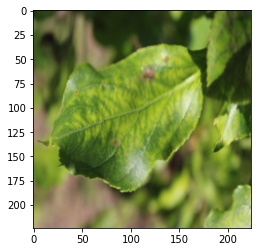

Label: 3


In [ ]:
train_features, train_labels = train_ds[0] #iter는 반복 가능한 객체에서 이터레이터를 반환하고, 
                                                        #next는 이터레이터에서 값을 차례대로 꺼냅니다. 
img = train_features
label = train_labels
plt.imshow(img.permute(1,2,0))
plt.show()
print(f"Label: {label}")

In [ ]:
train_loader = DataLoader(train_ds, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0) 
vali_loader = DataLoader(val_ds, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)
test_loader = DataLoader(val_ds, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
print(len(train_loader), len(vali_loader))
print(type(train_loader), type(vali_loader))

86 29
<class 'torch.utils.data.dataloader.DataLoader'> <class 'torch.utils.data.dataloader.DataLoader'>


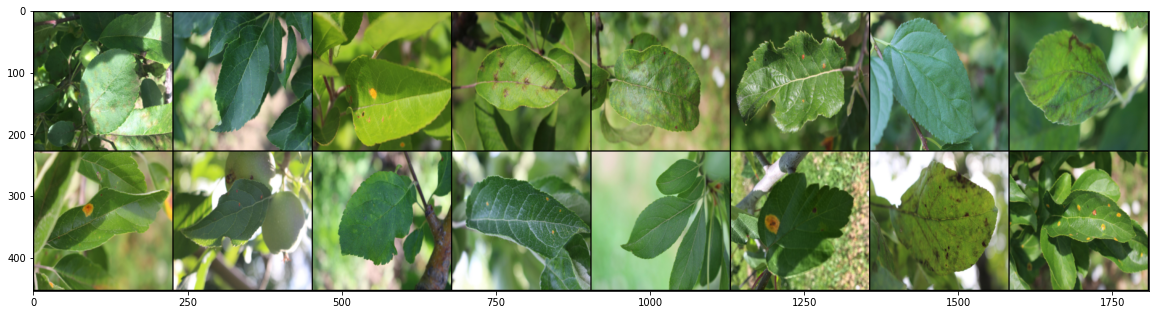

In [ ]:
def imshow(img):         
    #img = img * 0.5 + 0.5 #unnormalize (normalize : (data - 0.5)/0.5))
    plt.figure(figsize=(20, 200))
    plt.imshow(img.permute(1, 2, 0))

dataiter = iter(train_loader)
images, labels = dataiter.next() # 32개의 image, 32개의 label

imshow(torchvision.utils.make_grid(images, nrows=8))

# 모델 생성

## Resnet

In [ ]:
from torch import nn
from torch import optim
from torch.nn.modules.dropout import Dropout
import torch.nn.functional as F

cfg = [64,64,'M',128,128,'M',256,256,256,256,'M',512,512,512,512,'M',512,512,512,512,'M']

class VGG19(nn.Module):
    def __init__(self):
        super().__init__()        
        self.conv1 = self.makemodel_(cfg)
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(in_features=512, out_features=256), nn.LeakyReLU(),          
            nn.Dropout(0.3),
            nn.Linear(in_features=256, out_features=128), nn.LeakyReLU(),
            nn.Dropout(0.3),
            nn.Linear(in_features=128, out_features=64), nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(in_features=64, out_features=4),            
        )

    def forward(self, x):
        x = self.conv1(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
    

    def makemodel_(self, cfg):
        layers = []
        in_channels=3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else :
                layers += [nn.Conv2d(in_channels=in_channels, out_channels=x, kernel_size=3, padding=1),
                            nn.BatchNorm2d(num_features=x),
                            nn.Dropout2d(0.2, inplace=True),
                            nn.LeakyReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=7, stride=7)]

        # 64*224*224  >  64*112*112
        # 64*112*112  >  128*56*56
        # 128*56*56   >  256*28*28 
        # 256*28*28   >  512*14*14 
        # 512*14*14   >  512*7*7
        # 512*7*7     >  512*1*1
        return nn.Sequential(*layers)

In [ ]:
model = VGG19()
model.to(device) # model을 GPU로 보내기

VGG19(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout2d(p=0.2, inplace=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Dropout2d(p=0.2, inplace=True)
    (7): LeakyReLU(negative_slope=0.01, inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout2d(p=0.2, inplace=True)
    (12): LeakyReLU(negative_slope=0.01, inplace=True)
    (13): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(128, eps

# 모델 훈련

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

def validation(model, testloader, criterion):
    test_accuracy = 0
    test_loss = 0

    with torch.no_grad(): # 예측에는 gradient가 필요 없음
        for images, labels in testloader: # 1 iteration마다 배치 단위로 image와 label을 가져옴
            images, labels = images.to(device), labels.to(device) # data를 GPU로 보내기
            # Not Flatten!!!
            #images.resize_(images.shape[0], 784) # batch size x 784
            
            logits = model.forward(images) # 입력 : batch_size, 28, 28
            
            loss = criterion(logits, labels)
            test_loss += loss.item()

            probs = F.softmax(logits, dim=1)
            _, preds = torch.max(probs, 1) # preds = probs.max(dim=1)[1]
            correct = (preds == labels).sum()
            accuracy = correct / images.shape[0]
            test_accuracy += accuracy

    return test_loss, test_accuracy            

In [ ]:
learning_rate = CFG['LEARNING_RATE']
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=6, factor=0.1, verbose=True)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

def train(model, epochs, criterion, optimizer):
    steps = 0
 
    # 1 에폭(epoch)당 반복수
    #iter_per_epoch = len(trainset) / batch_size  
    iter_per_epoch = len(train_loader) 
    print_every = iter_per_epoch
    best_accuracy = 0

    # for Early stopping
    min_loss = 1000
    trigger = 0
    patience = CFG['EARLY_STOP']
    valid_accuracy = 0

    # learning
    valid_loss = 0
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for images, labels in tqdm(iter(train_loader)):
            steps += 1
            images, labels = images.to(device), labels.to(device)

            
            optimizer.zero_grad()

            # 1. Forward (Loss 얻게됨)
            output = model.forward(images)
            loss = criterion(output, labels)

            # 2. Backward (Gradient가 오차역전파로 구해짐)
            loss.backward()

            # 3. Gradient Descent (Model parameter update) :  W <- W-lr*Gradient
            optimizer.step() 

            train_loss += loss.item() # 1 epoch 당 누적된 로스
            
            if steps % print_every == 0 : 
                 # 배치 정규화, 드롭아웃 이 적용될 경우 model.forward 연산이 training 때와 다르므로 반드시 설정
                model.eval()
                valid_loss, valid_accuracy = validation(model, vali_loader, criterion)

                writer.add_scalar("Loss/train", train_loss/len(train_loader), epoch)
                writer.add_scalar("Loss/test", valid_loss/len(vali_loader), epoch)
                writer.add_scalars("Loss/train and valid",
                                { "train" : train_loss/len(train_loader),
                                    "test" : valid_loss/len(vali_loader) }, epoch)

                print("Epoch : {}/{}...".format(epoch+1, epochs),
                    " Train Loss : {:.3f}".format(train_loss/len(train_loader) ),
                    " Valid Loss : {:.3f}".format(valid_loss/len(vali_loader)),
                    " Valid Accuracy : {:.3f}".format(valid_accuracy/len(vali_loader)))
                
                # Early stopping Start 
                if valid_loss > min_loss: 
                    trigger +=1
                    print("trigger :", trigger)
                    if trigger > patience: 
                        print("Early Stopping!!!")
                        print("Train step is finished!!")
                        writer.flush()
                        writer.close() 
                        return
                else: 
                    min_loss = valid_loss
                    trigger = 0

                # Early stopping End
                train_loss = 0
                model.train()
            # Best model 저장
            if valid_accuracy > best_accuracy:
                torch.save(model.state_dict(), "./model_saved/best_model.pth")
                best_accuracy = valid_accuracy
            

        # Learning Rate Scheduler 
        scheduler.step(valid_loss)
    writer.flush()
    writer.close()        

In [ ]:
train(model, 150, criterion, optimizer)

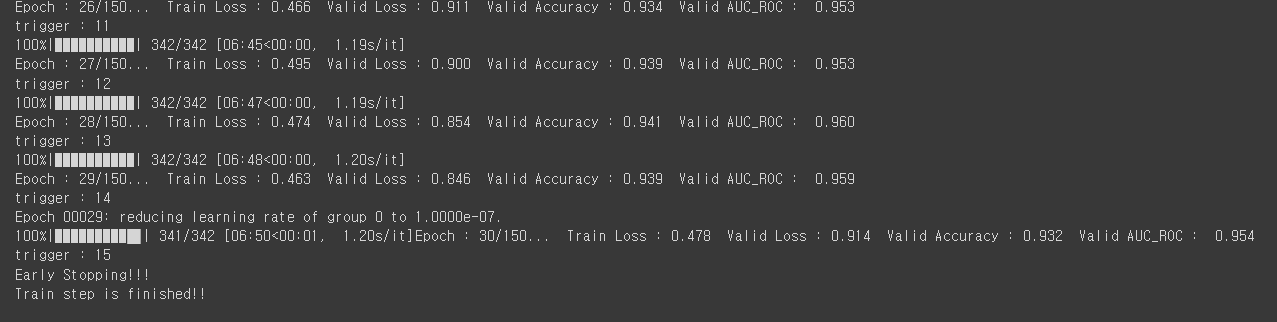

- 10시간의 훈련.

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir runs

# 모델 평가

In [ ]:
def evaluate(model, testloader):
    test_accuracy = 0
    test_loss = 0
    model.eval()
    with torch.no_grad(): # 예측에는 gradient가 필요 없음
        for images, labels in testloader: # 1 iteration마다 배치 단위로 image와 label을 가져옴
            images, labels = images.to(device), labels.to(device)
            # not Flatten!
            #images.resize_(images.shape[0], 784) # batch size x 784
            logits = model.forward(images) # 입력 : batch * height * width
            
            loss = criterion(logits, labels)
            test_loss += loss.item()

            probs = F.softmax(logits, dim=1)
            _, preds = torch.max(probs, 1) # preds = probs.max(dim=1)[1]
            correct = (preds == labels).sum()
            accuracy = correct / images.shape[0]
            test_accuracy += accuracy.item()

    print("Test Loss : ", test_loss/len(testloader))
    print("Accuracy : ", test_accuracy/len(testloader))

In [ ]:
# 마지막 학습결과를 저장 후 나중에 사용하기 원할 때
torch.save(model.state_dict(), "last_checkpoint.pth")
state_dict = torch.load("last_checkpoint.pth") 
last_model = VGG19() # 이미 model에 마지막 학습결과가 있으나 last_model로 다시 불러옴
last_model.to(device)
last_model.load_state_dict(state_dict) # model과 parameter를 매치 시키는 작업
evaluate(last_model, test_loader)

In [ ]:
# Test Accuracy 기준으로 가장 높을때의 모델 파라미터가 저장되어 있음
state_dict = torch.load("best_checkpoint.pth") 
best_model = VGG19()
best_model.to(device)
best_model.load_state_dict(state_dict)
evaluate(best_model, test_loader)